<a href="https://colab.research.google.com/github/paulantoine/covid_dept/blob/master/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import requests
import bs4 as BeautifulSoup
import matplotlib.pyplot as plt
#import seaborn as sns
#plt.style.use('fivethirtyeight') #'seaborn-notebook'
#plt.rcParams.update({'font.size': 14})il
import matplotlib.ticker as mticker
print(pd.__version__)

1.1.4


In [ ]:
pop_age = pd.read_excel("https://www.insee.fr/fr/statistiques/fichier/1892088/pop-totale-france-metro.xls", header=5)
pop_age.head(3)

,Année de naissance,Âge révolu,Nombre d'hommes,Nombre de femmes,Ensemble
0,2019,0,343009,329909,672918
1,2018,1,348625,333151,681776
2,2017,2,354653,340515,695168


In [ ]:
# lecture des données

def read_data(url, dataset_name, sep=","):
    r = requests.get(url)
    soup = BeautifulSoup.BeautifulSoup(r.text)
    ressources_list = soup.find("div", "resources-list")
    url = None
    for article in ressources_list.find_all("article"):
      if dataset_name in article.div.h4.text:
        url = article.find("a", "btn btn-sm btn-primary", download=True)["href"]
        break
    if url == None:
      raise("data not found")
    return pd.read_csv(url, sep=sep)

dept_data = pd.read_csv(
    "https://public.opendatasoft.com/explore/dataset/population-francaise-par-departement-2018/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B",
    sep=";",
    header=0,
    names=["code", "nom", "population"],
    index_col=0,
    usecols=[0,1,2]
    )

hospi_dept = read_data(
    "https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/",
    "donnees-hospitalieres-nouveaux-covid19",
    ";"
)
print("dernier jour hospitalisations par département :", max(hospi_dept.jour))

hospi_age = read_data(
    "https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/",
    "donnees-hospitalieres-classe-age-covid19",
    ";"
)
print("dernier jour hospitalisations par age :", max(hospi_age.jour))

cumul = read_data(
    "https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/",
    "donnees-hospitalieres-covid19",
    ";"
)

test_age = read_data(
    "https://www.data.gouv.fr/fr/datasets/donnees-relatives-aux-resultats-des-tests-virologiques-covid-19/",
    "sp-pos-quot-fra",
    ";"
).drop(columns=['fra'])
print("dernier jour tests par age :", max(test_age.jour))

sos_urgences = read_data(
    "https://www.data.gouv.fr/fr/datasets/donnees-des-urgences-hospitalieres-et-de-sos-medecins-relatives-a-lepidemie-de-covid-19/",
    "sursaud-corona-quot-dep",
    ";"
)
sos_urgences=sos_urgences[sos_urgences.sursaud_cl_age_corona == "0"]
sos_urgences.drop(columns=["nbre_pass_corona_h", "nbre_pass_corona_f"])
print("dernier jour sos médecins / urgences:", max(sos_urgences.date_de_passage))

dernier jour hospitalisations par département : 2020-11-04
dernier jour hospitalisations par age : 2020-11-04
dernier jour tests par age : 2020-10-31
dernier jour sos médecins / urgences: 2020-11-02


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [ ]:
def display_df(df, legend=None, title="", logscale=False):
  if not legend:
    legend=df.columns
  fig = plt.figure(figsize=(20,8))
  ax = plt.axes()
  if logscale:
      plt.yscale('log')
  ax.plot(df, marker="o")
  plt.xticks(rotation=75)
  plt.title(title, fontsize=22)
  plt.legend(legend, loc=2, fontsize=14)
  plt.grid()
  tick_freq = df.shape[0] // 60
  myLocator = mticker.MultipleLocator(tick_freq)
  ax.xaxis.set_major_locator(myLocator)
  plt.show()

def window(df, min_date="2020-01-01", max_date="2022-01-01"):
  if "jour" in df.columns:
    return df[(df.jour >= min_date) & (df.jour <= max_date)]
  return df[(df.index>= min_date) & (df.index <= max_date)]

def dept_name(dept=None):
  if dept:
    return dept_data.loc[dept,"nom"]
  else:
    return "France"

In [ ]:
def prepare_hospi_dept(dept=None):
  if dept:
    daily = hospi_dept[hospi_dept.dep == dept].set_index("jour")[["incid_hosp", "incid_rea"]]
  else:
    daily = hospi_dept.groupby(["jour"])[["incid_hosp", "incid_rea"]].sum()

  lissage_hebdo = daily.rolling(7, center=True).mean()
  lissage_hebdo.columns = ["hosp_lisse", "rea_lisse"]

  return pd.concat([daily, lissage_hebdo], axis=1)

def variation_hospi_dept(dept=None):
  df = prepare_hospi_dept(dept)
  return df[["hosp_lisse", "rea_lisse"]].pct_change().rolling(5, center=True).mean()

def prepare_hospi_age(ages=None):
  if ages:
    df = hospi_age[hospi_age.cl_age90.isin(ages)]
  else:
    df = hospi_age[hospi_age.cl_age90 > 0]
  return df.pivot_table(index="jour", columns="cl_age90", values="hosp", aggfunc=sum)

def prepare_rea_age(ages=None):
  if ages:
    df = hospi_age[hospi_age.cl_age90.isin(ages)]
  else:
    df = hospi_age[hospi_age.cl_age90 > 0]
  return df.pivot_table(index="jour", columns="cl_age90", values="rea", aggfunc=sum)

def variation_hospi_age(ages=None):
  df = prepare_hospi_age(ages)
  return df.rolling(7, center=True).mean().pct_change().rolling(5, center=True).mean()

def prepare_test():
  return test_age[test_age.cl_age90 == 0].set_index("jour").rolling(7, center=True).mean()

def variation_test():
  return prepare_test().pct_change().rolling(5, center=True).mean()

def display_hospi_dept(dept=None, min_date="2020-01-01", max_date="2022-01-01"):
  display_df(
    window(prepare_hospi_dept(dept), min_date, max_date),
    legend=["hospitalisations", "réanimation", "hospitalisation 7j", "réanimation 7j"],
    title=dept_name(dept)
  )
  print_latest_hospi(dept)

def display_rea_dept(dept=None, min_date="2020-01-01", max_date="2022-01-01", logscale=False):
  display_df(
    window(prepare_hospi_dept(dept)[["incid_rea","rea_lisse"]], min_date, max_date),
    legend=["réanimation", "réanimation 7j"],
    title=dept_name(dept),
    logscale=logscale
  )
  print_latest_hospi(dept)

def display_variation_hospi_dept(dept=None, min_date="2020-01-01", max_date="2022-01-01"):
  display_df(
      window(variation_hospi_dept(dept), min_date, max_date),
      legend=["hospitalisations", "réanimations"],
      title=dept_name(dept)
  ) 

def print_latest_hospi(dept=None):
  if dept:
    population = dept_data.loc[dept,"population"]
  else:
    population = dept_data.loc[:, "population"].sum()
  df = prepare_hospi_dept(dept)
  hospi_lisse = df["hosp_lisse"].dropna()[-10:]
  rea_lisse = df["rea_lisse"].dropna()[-10:]
  disp = ["incid_hosp", "incid_rea", "hosp_lisse", "rea_lisse"]
  print("\ndernières données : \n")
  print(df[disp].apply(np.rint).tail(4).head(1))
  print()
  print(f"hospitalisations pour 100k habitants {max(hospi_lisse)/ population * 100000:.2f}")
  print(f"réanimations pour 100k habitants     {max(rea_lisse)/ population * 100000:.2f}")



In [ ]:
#display_variation_hospi_dept("75")
#display_df(window(prepare_hospi_age([0]), min_date="2020-08-01"), title="par âge")
#display_df(window(prepare_rea_age()),title="par âge")
#display_df(variation_hospi_age([19, 29, 69, 79, 89]), title="par âge")
#display_df(variation_test()[["P"]])

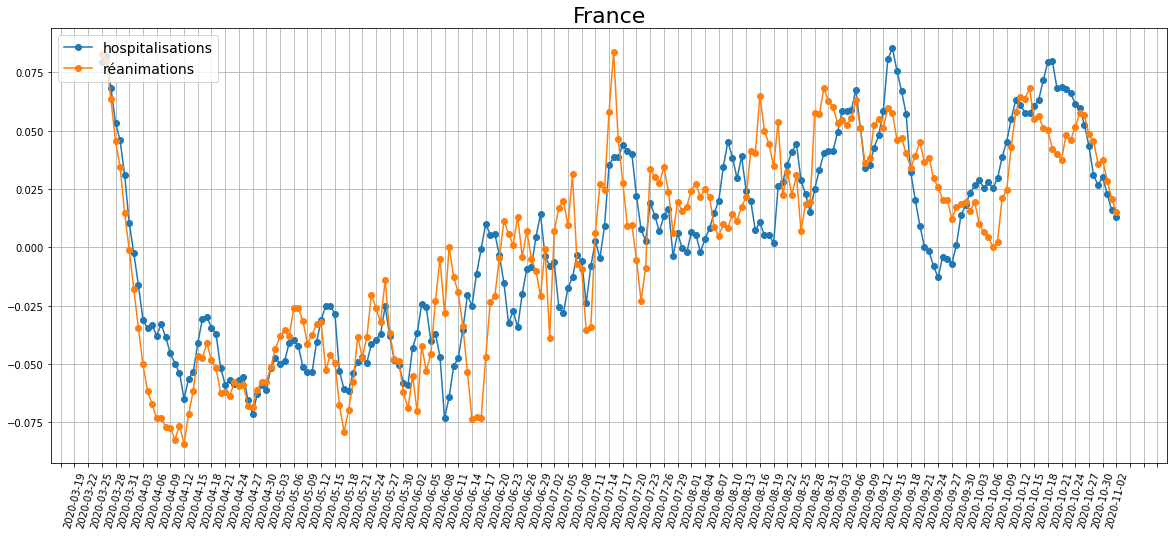

In [ ]:
display_variation_hospi_dept()

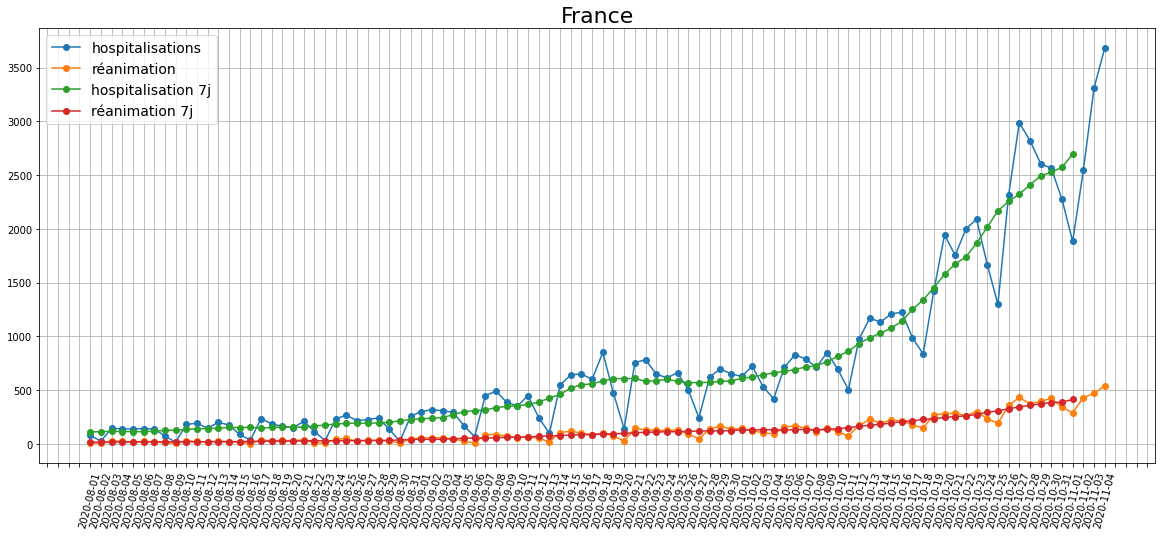


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-11-01      1883.0      289.0      2695.0      412.0

hospitalisations pour 100k habitants 4.01
réanimations pour 100k habitants     0.61


In [ ]:
display_hospi_dept(min_date="2020-08-01")

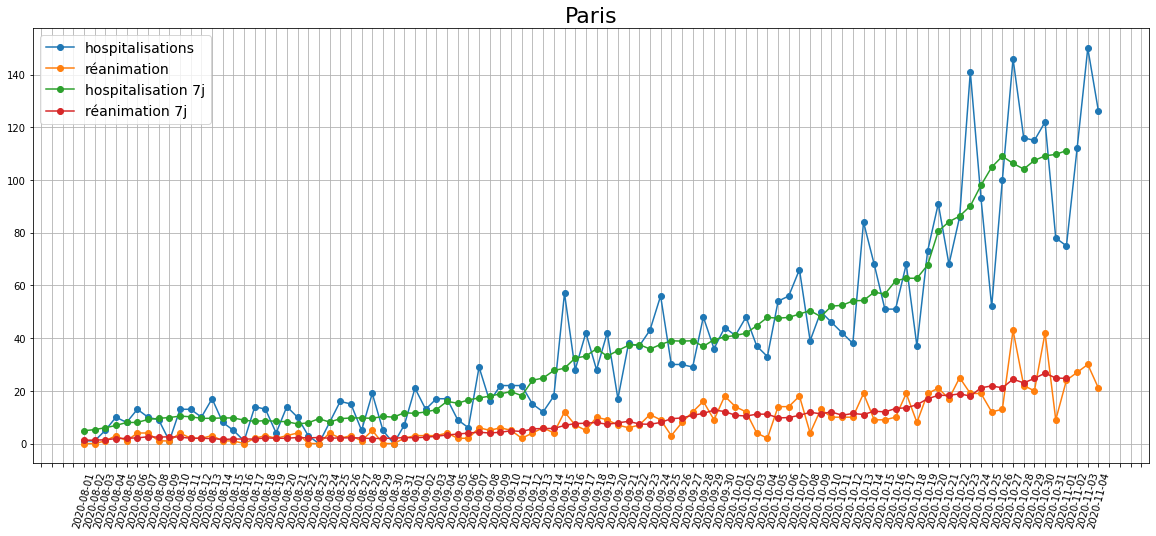


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-11-01        75.0       24.0       111.0       25.0

hospitalisations pour 100k habitants 5.13
réanimations pour 100k habitants     1.23


In [ ]:
display_hospi_dept("75", min_date="2020-08-01")

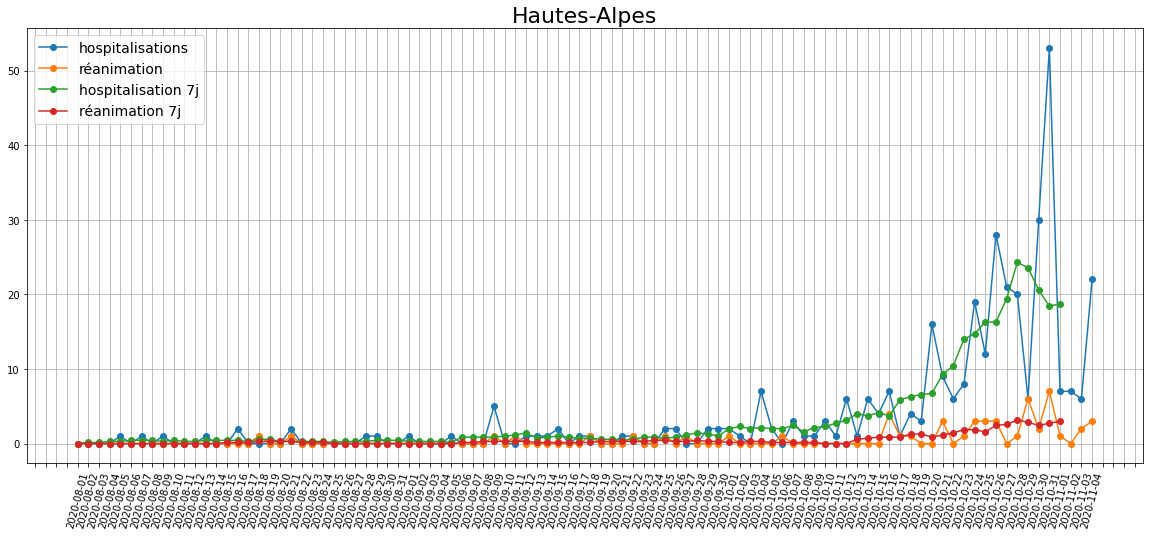


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-11-01         7.0        1.0        19.0        3.0

hospitalisations pour 100k habitants 17.15
réanimations pour 100k habitants     2.22


In [ ]:
display_hospi_dept("05", min_date="2020-08-01")

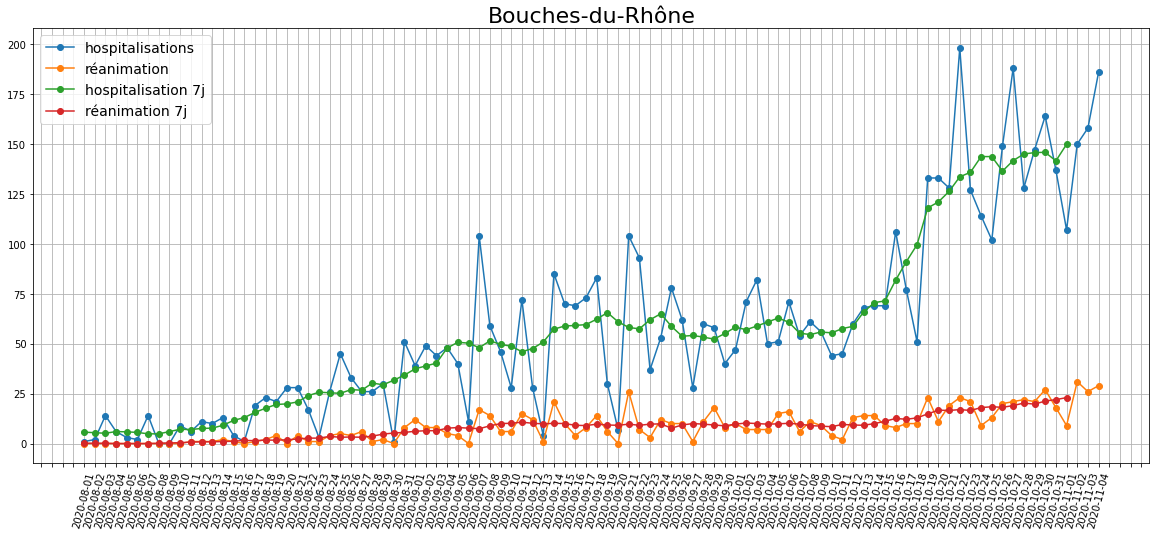


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-11-01       107.0        9.0       150.0       23.0

hospitalisations pour 100k habitants 7.33
réanimations pour 100k habitants     1.13


In [ ]:
display_hospi_dept("13", min_date="2020-08-01")

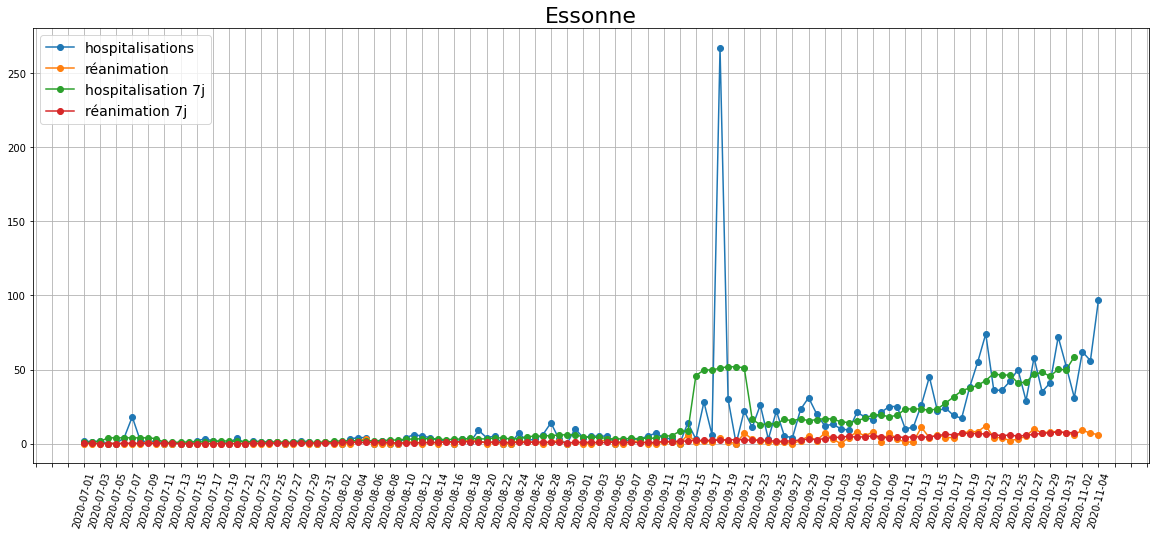


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-11-01        31.0        6.0        59.0        7.0

hospitalisations pour 100k habitants 4.47
réanimations pour 100k habitants     0.60


In [ ]:
dept = "91"
display_hospi_dept(dept, min_date="2020-07-01")

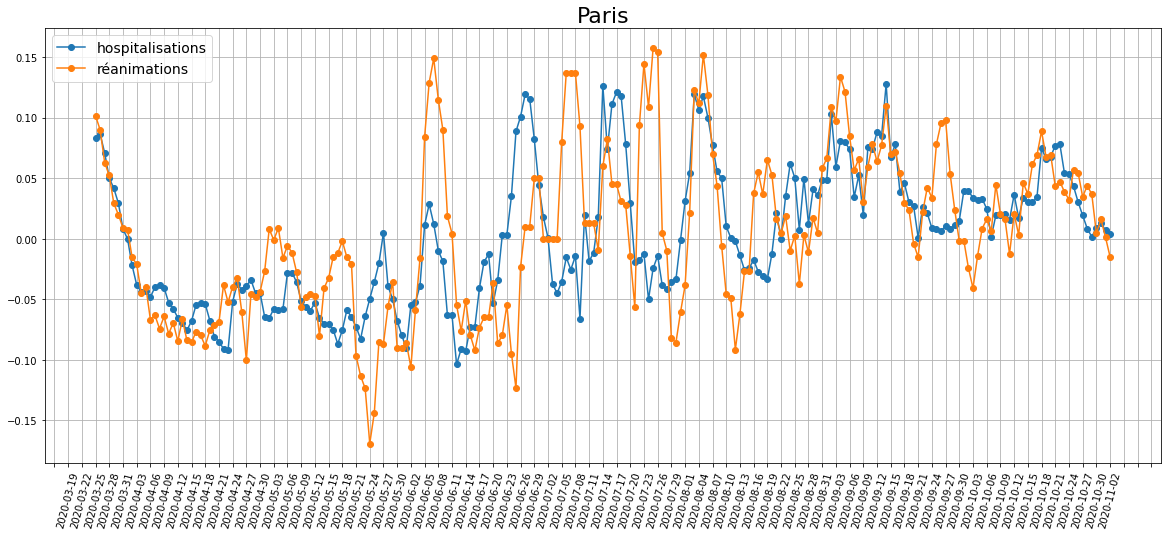

In [ ]:
display_variation_hospi_dept("75")

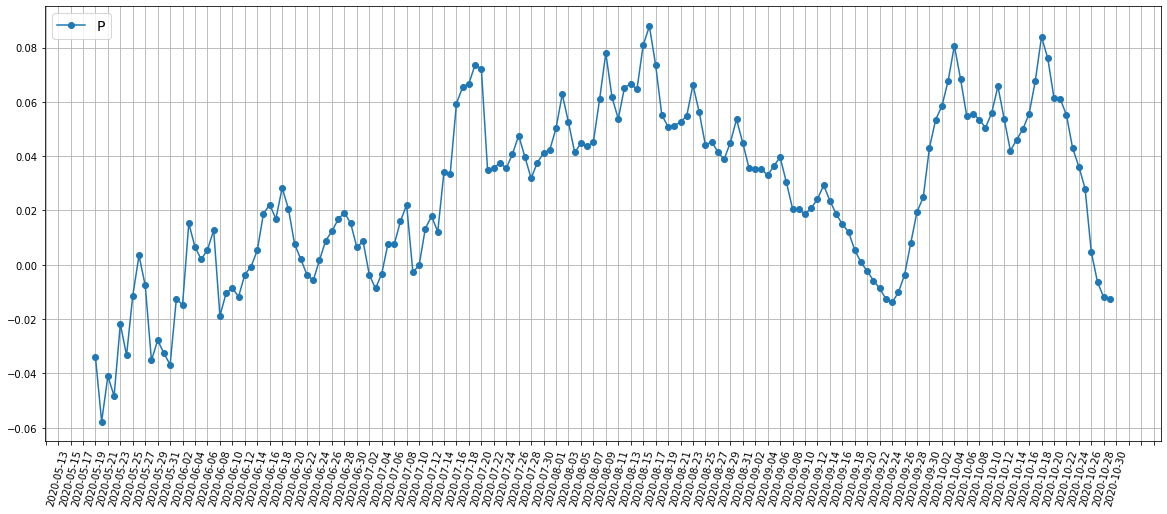

In [ ]:
display_df(variation_test()[["P"]])

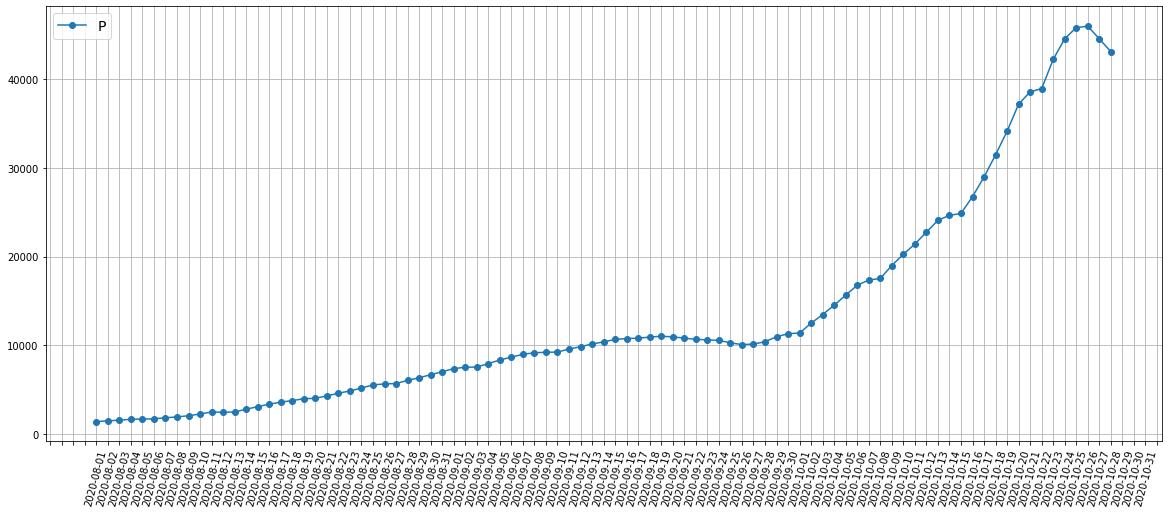

In [ ]:
display_df(window(prepare_test(), min_date="2020-08-01")[["P"]])

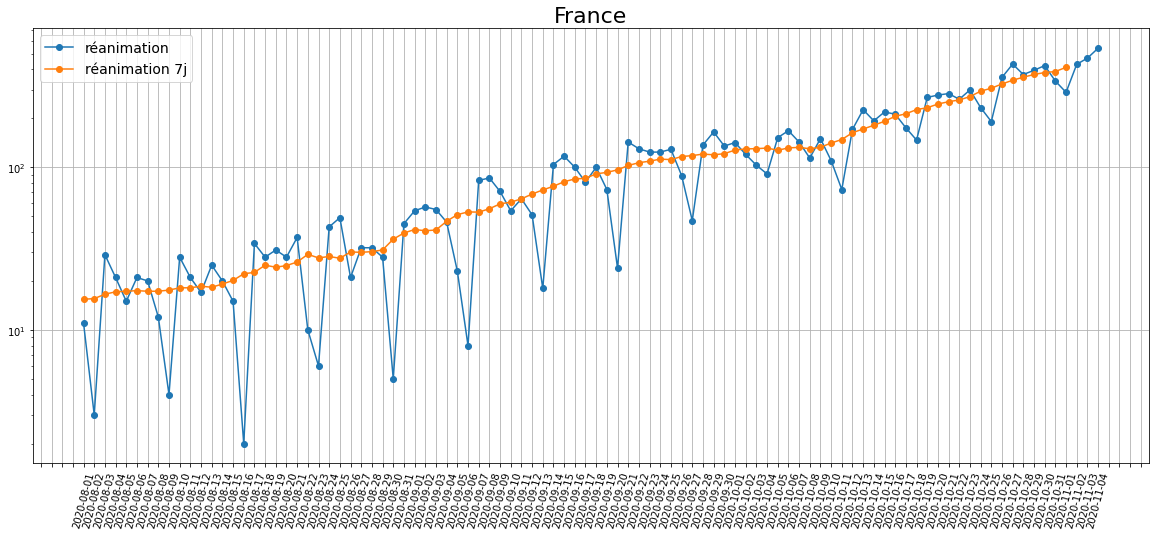


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-11-01      1883.0      289.0      2695.0      412.0

hospitalisations pour 100k habitants 4.01
réanimations pour 100k habitants     0.61


In [ ]:
display_rea_dept(min_date="2020-08-01", logscale=True)

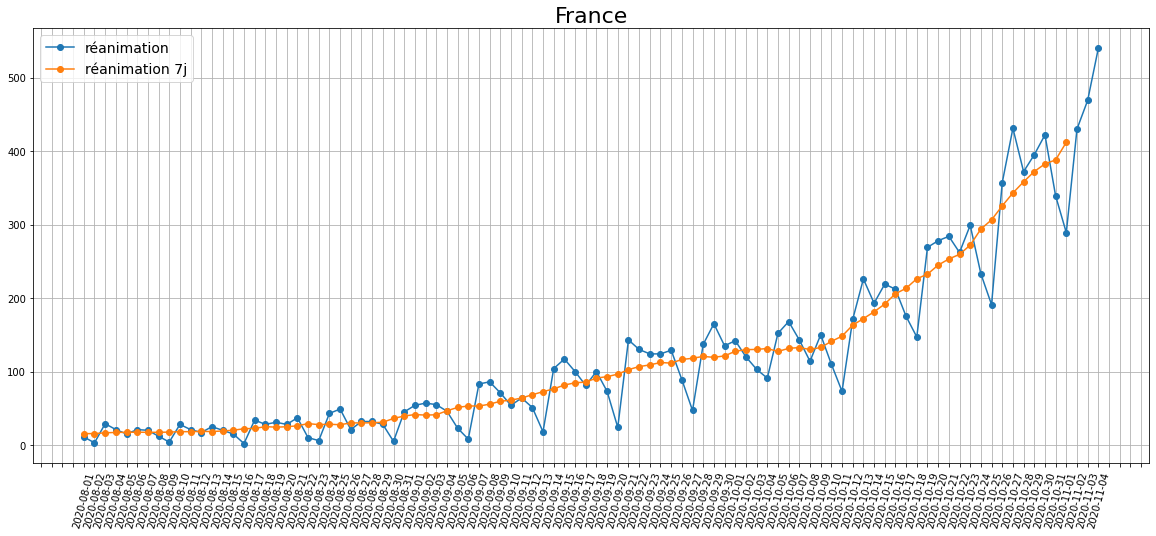


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-11-01      1883.0      289.0      2695.0      412.0

hospitalisations pour 100k habitants 4.01
réanimations pour 100k habitants     0.61


In [ ]:
display_rea_dept(min_date="2020-08-01")

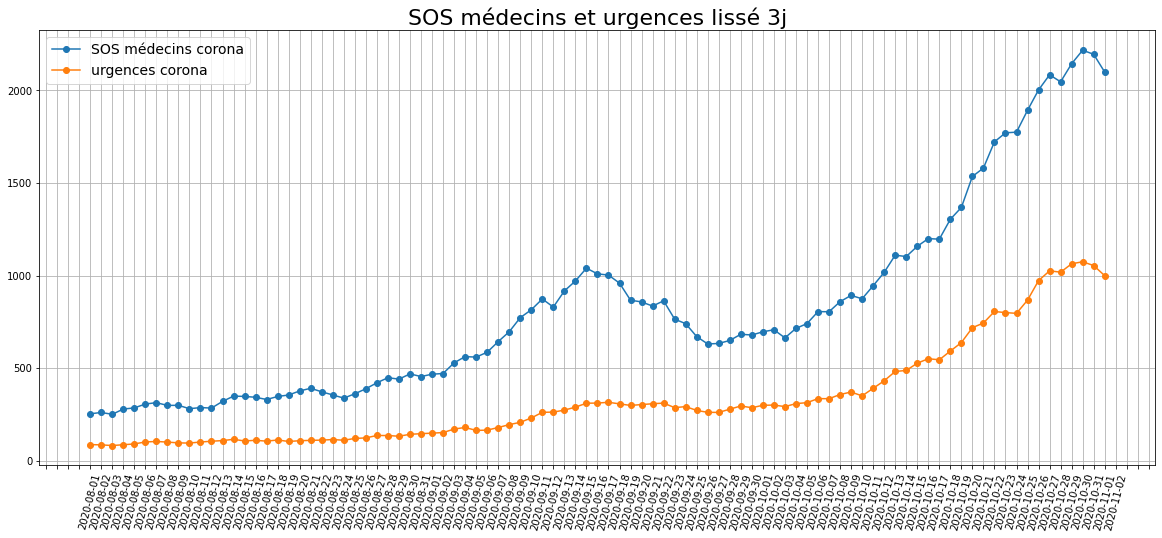

In [ ]:
lissage = 3
display_df(window(
    sos_urgences.groupby(["date_de_passage"])[["nbre_pass_corona", "nbre_hospit_corona"]].sum().rolling(lissage, center=True).mean(),
    min_date="2020-08-01"),
    legend=["SOS médecins corona", "urgences corona"],
    title = f"SOS médecins et urgences lissé {lissage}j"
)

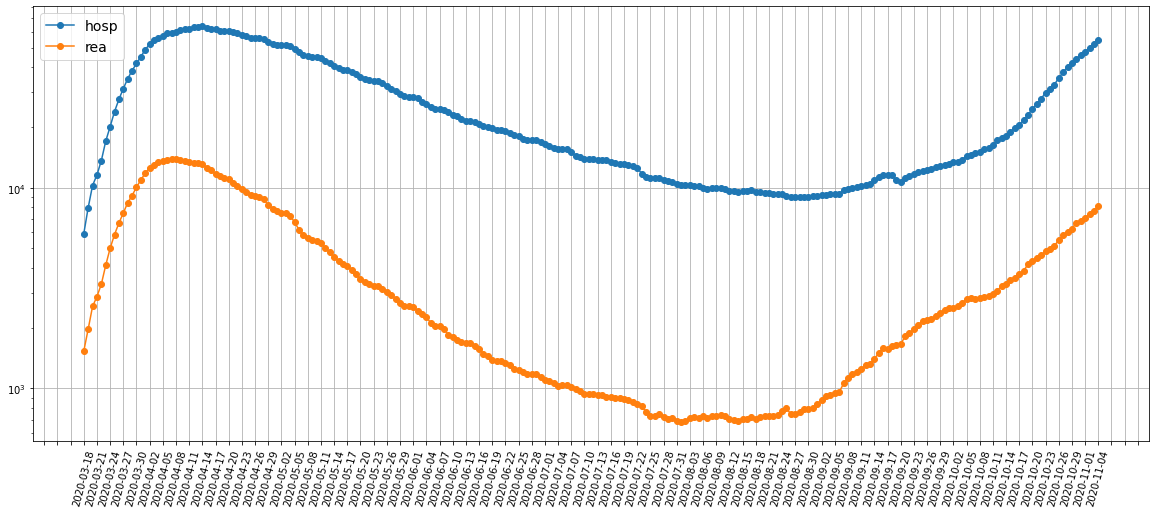

In [ ]:
c = cumul.groupby(["jour"])[["hosp", "rea"]].sum()
display_df(c, logscale=True)

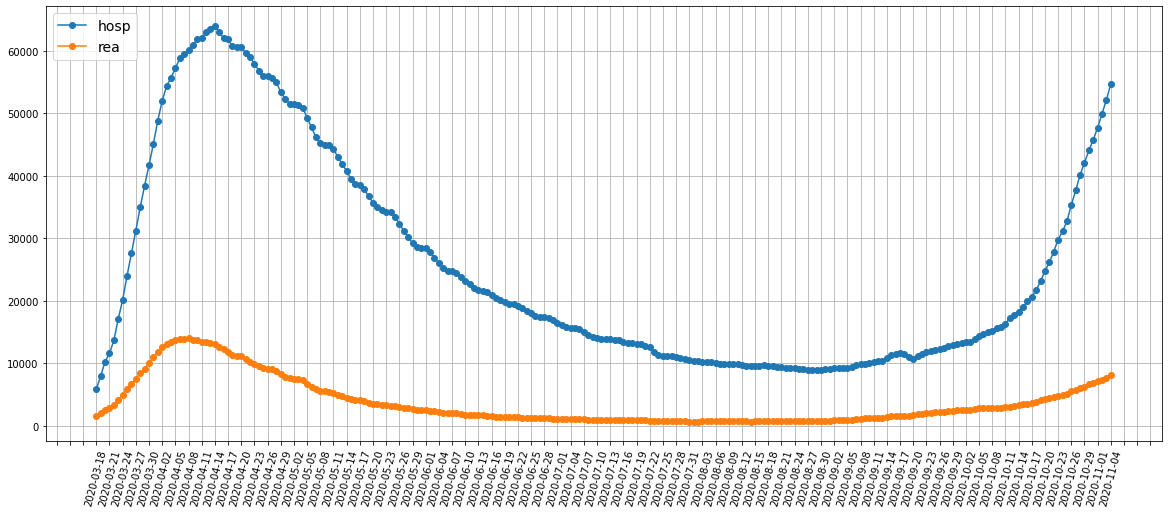

In [ ]:
display_df(c)